In [1]:
%matplotlib inline

from typing import *
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import functools
import math
import random


from collections import namedtuple
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import torch
import functools
import os

In [55]:

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, 20)
        self.w1 = nn.Parameter(torch.randn(20, 10))
        self.w2 = nn.Parameter(torch.randn(10, 20))

    def forward(self, x):
        # if x.sum() > 0:
        #     return x
        # x += 1
        z = self.fc.weight
        # return x @ z.T + self.fc.bias
        # x = torch.lerp(x, torch.zeros_like(x), 0.5)
        # return x + torch.zeros_like(z).sum() + self.fc(x).sum()
        # x = x + x.abs()
        x = self.fc(x)
        x = x @ (self.w1 @ F.gelu(self.w2)).tanh()
        y = self.w1.pow(2)
        x = F.log_softmax(x, dim=-1) * self.fc(x[..., :10]).mean() - y.mean()
        return self.fc(x[..., :10].abs()).mean() + self.fc2(x).mean()
        return x



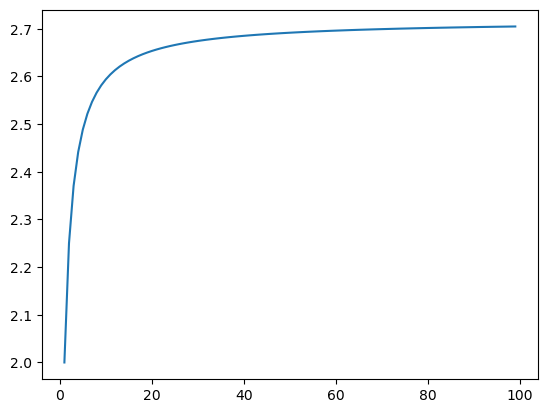

In [109]:
x = torch.arange(1, 100)

plt.plot(x, (1 + 1/ x)** x)
plt.show()

In [60]:
r'''

-------------------------------------------------------------------------------------------------------------------------------------

[ NOTE ] Assumption: Alignment in neural nets

Alignment refers to the phenomenon that, as learning progresses, the operator inputs often nearly attains the op-norm
bound for the weight matrices [1] or weight updates [2].

Therefore, the usual "gaussian random input" assumption is violated. Hence, when we consider an intermediate tensor
being in a norm ball, we generally assume that it lives on the shell and attains the norm ball bound. (!important)

Furthermore, in computing operator norms, we often assume that its entries are "balancedly distributed", e.g., has
balanced signs for ReLU. It remains an open question on how this is consistent with the alignment phenomenon.

NOTE that however, we do not make this assumption for the perturbations of weights or inputs.

[1] Scaling Exponents Across Parameterizations and Optimizers
[2] A Spectral Condition for Feature Learning

-------------------------------------------------------------------------------------------------------------------------------------

[ NOTE ] PT2 converted graph and Modula

There are two things in a PT2 converted graph (we use torch.export):
    1. A module, represented as f(x; w), with certain traits set so we can reason about the parameter
    2. An op, represented as f(x), enforced to be an ATen core op (`torch.ops.aten.*`) see https://pytorch.org/docs/main/torch.compiler_ir.html#core-aten-ir

The goal of modula conversion is to reason about norms so that all modules and ops become "well-normed". In original modula, a module is
single-input, single-output, single-paramter operator, defined with f(x: Tensor | TensorList, w: Tensor) -> y: Tensor, with a few addition constants
set so that it is well-normed (depending on the operation in f, and the norm spaces placed on x and y). And an op is a parameter-less module.

    To handle the general case, there is a special multi-input single-output operator Concat(*args) -> args that essentially just takes a few inputs and
    return the list that contains them. Its norm is the l1 sum of each element's norm.

Assuming the reader understands the modula paper, we now discuss the most important difference we need to handle:

    How do we handle complex modules with multi-input, multi-param, multi-output? What does mass, sensitivity attach to?

-------------------------------------------------------------------------------------------------------------------------------------

[ NOTE ] The API of PT2 Modula

THE TRICKY PART is that we want to support the multi-input, multi-param, multi-output case.

THE KEY APIs, on a high-level,are:
    + TensorMeta
    + ParamMeta(TensorMeta)
    + SimpleOpMeta, a multi-input, multi-param, single-output operator
    + ModuleMeta, containing multiple ParamMetas and multiple SimpleOpMetas. NOT attached to any particular input/output.
    + NodeMeta, containing a SimpleOpMeta, multiple ParamMetas, and multiple TensorMetas (inputs). Attached to a particular input/output pair.

'''
@attrs.define(kw_only=True)
class TensorMeta:
    # A tensor is either a parameter or an intermediate (eg, output of an operator).
    #
    # This defines the norm SPACE of a tensor.

    # The NORM of a tensor is defined by its norm_kind (one of rms, l1, l2, or operator-norm between two spaces)
    norm_kind: str

    # NORM_SIZE is the size of the tensor (assuming alignment, see [ NOTE ] Assumption: Alignment in neural nets)
    norm_size: float = 1


@attrs.define(kw_only=True)
class ParamMeta(TensorMeta):
    state_dict_key: str  # the key in state_dict of the full module

    # How much feature learning is attributed to this paramter: under maximal update, how much output changes with 1 update on this parameter
    mass: float


@attrs.define(kw_only=True)
class SimpleOpMeta:

    @attrs.define(kw_only=True)
    class BoundSimpleOpMeta:
        args_spec: Tuple[pytree[TensorMeta], ...]
        kwargs_spec: pytree[TensorMeta]
        param_spec: pytree[ParamMeta]
        out_spec: TensorMeta
        op_norm_bound: float

    def meta_forward(self, args_spec: Tuple[pytree[TensorMeta], ...], kwargs_spec: pytree[TensorMeta], param_spec: pytree[ParamMeta]) -> (TensorMeta, float):


    + MASS is a per-parameter concept:
        + How much feature learning is attributed to this paramter: under maximal update, how much output changes with 1 update on this parameter

    + Each OUTPUT of a MODULE is viewed as a SINGLE-OUTPUT OPERATOR (SOOp for short).
        + All SOOps of a MODULE share the same INPUTs and PARAMETERs.
        + Given {input} and {param} (with all the norm information above), we can compute the norm information for the output.

    + SENSITIVITY is a per-(SOOp x INPUT) concept (ie, per-OUTPUT-per-INPUT):
        + Bounds the SOOp's sensitivity to INPUT perturbations, i.e., the op-norm bound of the SOOp.

        + Input is assumed to be uniformly distributed on a certain norm sphere (see [ NOTE ] Assumption: Alignment in neural nets).

        + This generally depends on {parameter.norm_size}.

        + Sometimes the _uniform distribution on norm sphere_ assumption is crucial to compute the senstivity in a reasonable and consistent way.
           + If we instead consider the full norm ball, some op could have arbitarily large sensitivity, e.g., AddBias with near zero input.
           + If we do not assume uniform distribution, some op would have different sensitivity, e.g., ReLU would have sensitivity 1 rather than 0.5, which
             is likely too loose since it implies that the network always operates in the linear regime.

    + OP_NORM_COEFF is a per-(SOOp x PARAMETER) concept (ie, per-OUTPUT-per-PARAMETER):
        + Defines the bound of SOOp's sensitivity to PARAMETER perturbations.

          In particular, it defines a NORM over the parameter space, under which the SOOp is Lip-1 over parameters for any input.
          Equivalently, it is a norm over W such that the set of linear maps {\nabla_w op(x, w)}_{x,w} all have operator norm at most 1.

          For examples,
            1. a linear layer without bias has linear maps { \nabla_W Wx }_{x,W} = { x }, where each map is defined
               as W -> Wx. For input space X := rho * unit RMS ball. The output (RMS) norm is rho * ||W||_rms-rms, so it is a valid choice.
            2. an add bias operation has linear maps { \nabla_b (x+b) }_{x,b} = { I }, where each map is defined
               as b -> b. The output (RMS) norm is ||b||_rms, so it is a valid choice.

        + As seen above, this norm
            + generally depends on {input.norm_size}, e.g., to determine the scale of the ||W||
            + does not depend on {parameter.norm_size} when the operation is linear in the parameter

        + Each SOOp is assumed to be "primitive" enough so that this norm can be written as a weighted MAX combination
          of parameter norms `max(b1 ||W1||, ...)`.

          Unlike SENSITIVITY, this uses a weighted MAX combination of parameter norms. According to @jbxz:

                > Two reasons for this. Taking M.norm to be max rather than sum
                > 1. gives much tighter sharpness bounds in M.norm
                > 2. induces a "duality map" that leads to training all layers every step. The sum combination would only update
                >    one layer per step which feels unnatural

        + Our goal is to compute the {b_i}_i, for each SOOp (ie, each output).

        + For a composed operation, e.g., linear := add_bias \circ matmul_weight, the key for computing these {b_i}_i is to

            + Assume that other ops attain their upper bounds. Therefore, there is no higher order terms. (*)

            + When each sub-op has valid param norm, we can compose them together using weighted MAX:

                (M2 \circ M1).norm((W1, W2)) := max(
                    M2.sensitivity * (total_mass/mass_1) * ||W1|| * possible_op_dependent_scale_for_w1,
                                     (total_mass/mass_2) * ||W2|| * possible_op_dependent_scale_for_w2,
                )

              (max_over_sum: note that \max(p x1, q x2) \geq x1 + x2, if p + q = 1, which extends to multiple terms easily.)

              In general, ||W1|| depends on the input and output norm spaces of M1, and `possible_op_dependent_scale_for_w1`
              depends on the norm_size of input to M1.

              In original jbxz/modula repo, this is wildly simplified
                1. all atoms assume unit-norm input
                2. some modules do not output unit-norm tensors
                3. they usually have scaled versions that do.

              They only use modules of the first and the last type.

              We will do the general thing since we track {input.norm_size}.

        + (max_over_sum) may be helpful to come up with proper {b_i}_i.

        + The modula way to handle multi-input and multi-parameter is to conceptually use a Concat module, which employs
          the SUM-reduced norm on concatenated tensors and the mass-weighted MAX-reduced norm on parameters.

    + SENSITIVITY and OP_NORM_COEFF together define the op-norm bound of composed modules / chained ops because we ignore
      higher-order terms (see (*)).

      In particular, we chain things together using (chain_w_unit_input) or (chain_w_propagated_input), depending on the global OpNormMode.

A PARAMETER is a tensor with tunable MASS and NORM_BOUND.                                                        # ParamMeta

An SINGLE-OUTPUT OPERATOR (SOOp for short) has
    + forward(args, params) -> one_out_tensor, and                                                               # SingleOutputOpMeta
    + forward_meta(arg_meta_fns: List[Callable[[], TensorMeta]], param_metas) -> (out_tensor_meta, float[param_metas]).

        The RVs are out_tensor_meta: TensorMeta and op_norm_coeffs: float, where the float is the op-norm bound of the SOOp.

        We use callables rather than materialized TensorMeta to defer the computation that could depend on
        some parameters' MASS and NORM_BOUND, so that eventually we can build a "pure" function that
        maps parameters' MASS and NORM_BOUND to objects of interest.

        See [ NOTE ] Our goal below.

A MODULE consists of essentially                                                                                 # ModuleMeta
    + a collection of paramters as a pytree[ParamMeta]
    + a collection of SOOps as a pytree[SingleOutputOpMeta], one for each output Tensor.

        Then, given `arg_meta_fns`, we can build a `Callable[[], out_tensor_meta]` for each output tensor, which
        can then be used as input to the next operator

    + forward_meta(arg_meta_fns: List[Callable[[], TensorMeta]], param_metas) -> pytree[Callable[[], TensorMeta]]
      as defined above.

We provide support for the following MODULEs (incl. ops):
    + `nn.Linear`
    + `nn.LayerNorm`
    + `nn.MultiheadAttention`
    + `torch.ops.aten.matmul`
    + `torch.ops.aten.add`
    + `torch.ops.aten.mul`
    + `torch.ops.aten.relu`
    + `torch.ops.aten.gelu`

We use PT2 to get fx.Graph that consists of the above modules and ops (along with `getitem`).
Each fx.Node.meta['modula'] contains the following:                                                               # NodeMeta
    + `module`: ModuleMeta
    + `out_meta_fn`: Callable[[], TensorMeta]

-------------------------------------------------------------------------------------------------------------------------------------

[ NOTE ] Our goal:

Given a PT2 converted graph, generate a computation mapping that takes in
    + {parameter.op_norm_bound} and {parameter.mass} for each parameter
produces
    + {output.op_norm_bound} for each output
    +
1. generate a computation mapping from {parameter.op_norm_bound} and {parameter.mass} to {output.op_norm_bound}

-------------------------------------------------------------------------------------------------------------------------------------


[ NOTE ] Modules with alternative computation defintions: e.g., biased linear modules

There are, as usual, multiple ways to define a module computation and thus the norms. E.g., a biased linear module can
be viewed as either
  MatMul \circ AppendOne
OR
  AddBias \circ MatMul

Some of these formulations may be nicer than others. E.g., AddBias does not have bounded op-norm. Now the modula way
is to assume input has some certain constaint bounded norm, and derive an op-norm by division (e.g., RMSDivide in eq B.14).

We do three modes: OpNormMode.EXACT_BOUND, OpNormMode.EST_FROM_UNIT_INPUT, OpNormMode.EST_FROM_PROPAGATED_INPUT. Names
are self-explanatory, and the modula default is OpNormMode.EST_FROM_UNIT_INPUT. And EXACT_BOUND should work for all inputs,
but could error out.

To support different ways to formulate parameters for biased linear modules, we provide a flag

THIS MEANS THAT FOR BIASED LINEAR MODULES, we consider it as MatMul \circ AppendOne. The alternative, which uses AddBias,
does not have bounded op-norm. This means that we consider parameters in a possibly different way than state dict. Hence,
we consider a concept called param_dict, which is the parameters suitable for Modula. We implement this modification for
(1) nn.Linear (2) nn.LayerNorm (where .weight has Linf as op norm) (3) nn.Conv2d. But it can be generally extended, if needed.

-------------------------------------------------------------------------------------------------------------------------------------

now there is one important possible traits of modules:
1. ($*$) scale-flex (general), for any w, alpha, exists w' s.t. for any x, alpha f(x, w) = f(x, w'). e.g., conv, fc, etc

in practice, we will just focus on ones that transfer the scale to w', i.e., linear in w:
1. scale-flex, for any w, alpha, for any x, alpha f(x, w) = f(x, alpha w'). e.g., conv, fc, etc


there is one important possible traits of modules & ops
2. scale-inv, for any w, for any x, alpha, f(x) = f(alpha x), e.g., layer norm, rmsnorm

'''



Each tensor should have
```py
class TensorMeta:
    # we consider scaled versions of a few norms
    # i.e., ||x|| := ||x||_norm_kind * norm_scale
    norm_kind: str               # [rms, l1, l2, or *-*]
    norm_scale: float = 1

    mass: Optional[Tensor]       # set iff this is parameter, see
    norm_size: float = 1         # Size of current tensor, settable iff is_parameter.

    tensor_meta: FakeTensor

    def to(self, other: TensorMeta) -> TensorMeta:
        # if just rescaled version of other, convert norm_bound so that we have other.norm_kind, other.norm_scale
        ...
```

Each node should have (see later for more)
```py
class NodeMeta:
    components: pytree[TensorMeta]
```

We define
```py
def norm(tensors: pytree[Tensor], meta: pytree[TensorMeta], *, dual: bool = False, dualized: Optional[pytree[Tensor]] = None) -> pytree[float]:
    # support rms, l1, l2, l2-l2 (spec), rms-rms (scaled spec), l1-rms, nuclear
    ...

def initialize_with_maximal_unit_norm(meta: pytree[TensorMeta]) -> pytree[Tensor]:
    ...

def dualize(tensors: pytree[Tensor], meta: pytree[TensorMeta]) -> pytree[Tensor]:
    ...
```

NB: the modula norm, operating on a state-dict-like collection of weights (except it is on param dicts that could possibly differ, see ModuleMeta),
is essentially a `pytree[TensorMeta]`, defined as
```py
class ModulaNorm:
    comp_spec: pytree[TensorMeta]

    def state_dict_to_param_dict(self, pytree[ModuleMeta], pytree[Tensor]) -> Tensor[param_spec]:
        ...

    def param_dict_to_state_dict(self, pytree[ModuleMeta], Tensor[param_spec]) ->  pytree[Tensor]:
        ...


    def norm(self, tensors: Tensor[comp_spec], dual: bool = False, dualized: Optional[pytree[Tensor]] = None) -> float:
        # reduction is max, dual of that is sum (ie, l1 linf) (TODO: support different reduction at different levels?)
        ...

    def normalize(self, tensors: Tensor[comp_spec]) -> Tensor[comp_spec]:
        # W_i -> (W_i / ||W_i||) / coef_i
        ...

    def dualize(self, tensors: Tensor[comp_spec], scale_with_dual_norm: bool = True) -> Tensor[comp_spec]:
        # G -> dualize(G) / coef_i
        # OR
        # G -> dualize(G) * ||G||^\dagger / coef_i
        ...

    def initialize(self) -> Tensor[comp_spec]:
        ...
```

The traits we track for both module and ops are:
```py


class ModulaOpInterface:
    # mass, the amount of feature learning a single application of this op gives
    mass: float
    # sensitivity
    op_norm_bound: float   # this is probably a property, since it depends on tensor norm and bounds


class ModuleMeta(ModulaOpInterface):
    # mass
    mass: float = float(has_param)

    param_spec: pytree[TensorMeta]
    has_param: bool                 # property (i.e., module vs op)

    def state_dict_to_param_dict(self, pytree[Tensor]) -> Tensor[param_spec]:
        ...

    def param_dict_to_state_dict(self, Tensor[param_spec]) ->  pytree[Tensor]:
        ...

    scale_flex: bool
    scale_inv: bool

    def build_out_spec(self, in_spec: pytree[TensorMeta]) -> pytree[TensorMeta]:
        # use TensorMeta.to for implicit conversion
        pass

    # sensitivity
    def op_norm_bounds(self, in_spec: pytree[TensorMeta]) -> (float[param_spec])[out_spec]:
        # using OpNormMode, generate `b_i` coeffs for each output


```

a comp graph must be consisted entirely with modules & ops that satisfy these. we provide initial ones for the following pytorch module & ops:
1. `nn.Linear`
2. `nn.LayerNorm`
3. `torch.ops.aten.add`
3. `torch.ops.aten.relu`
4. `torch.ops.aten.gelu`

based on above, we can compute the following on each node of the graph `res := op(*args)`, which is a tensor, using also modula concat rules:
(the key is to consider the module from overall input -> here)
```py
class NodeMeta(ModulaOpInterface):
    # mass
    mass: float = float(has_param)
    # sensitivity
    op_norm_bound: float   # property

    module: ModuleMeta
    args: pytree[NodeMeta]  # yep, traced nodes only have args

    in_spec: pytree[TensorMeta] = map(lambda arg: arg.out_spec, args)
    out_spec: pytree[TensorMeta] = module.build_out_spec(in_spec)

    def build_cat_arg_coeffs

res._cat_arg_mass:                    float                  := sum(arg.mass for arg in args)                                          # mass of the op from input -> (args),    defn 4.b
res._cat_arg_op_norm_bound:           float                  := sum(arg.op_norm_bound for arg in args)                                # op norm of the op from input -> (args), defn 4.c
res._cat_arg_op_norm_weight:          float[op.in_spec]      := op.in_spec.unflatten([res.cat_arg_mass / arg.mass for arg in args])    # coeffs in ||_M from input -> args,      defn 4.d

res.out_spec = op.out_spec
res.norm:                            float[op.out_spec]     := map(lambda x: x * res.cat_arg_op_norm_bound, op.op_norm_bound)         # norm of each output
res.mass:                            float                  := res.cat_arg_mass + op.mass                                             # mass of the op from input -> here,      defn 3.b
res.op_norm_bound:                   float                  := res.cat_op_norm_bound * op.op_norm_bound                               # op norm of the op from input -> here,   defn 3.c
res.op_norm_weight:                  float[dict(in=op.in_spec, param=op.param_spec)]
                                                            := [[[input]]]   (res.mass / arg.mass) * res.cat_arg_op_norm_weight[arg] * op.op_norm_bound                       # defn 3.d
                                                            := [[[param]]]   (res.mass /  op.mass) * op.op_norm_weight[param]                                                 # defn 3.d
```
then we can backfill
```py
op.param_spec[param].norm_scale
```

The goal is to, after given a module, reason about norms and assign `op_norm` so
1. each intermediate & output result is well-normed, assuming input rms=1


```
[[ Note ]] Feature learning and mass
the current definition of M.mass is agnostic to lip, which is weird.

model(x) := g(x) + f(x) * 1e-10 vs model(x) := g(x) * 1e-10 + f(x)

both f has the same mass, which is supposedly "the amount of feature learning done by f", yet f in the latter matters way more. Intuitively, these gs and fs should not have the same amount of feature learning, but they share the same .mass.

Looking at prop 3 (feature learning is apportioned by mass), we can see that the scaling in RHS with M.norm(\Delta w). To achieve equal effect on output, each module should have M_k.mass = 1/s_k so that unit change in \Delta w could lead to unit change in Y.

So it feels more intuitive to say that M_k.mass * s_k is the amount of feature learning done by M_k.
```


SyntaxError: invalid syntax (1608694625.py, line 198)

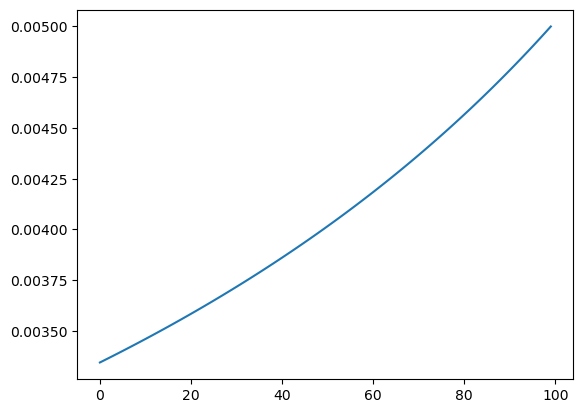

tensor([299.0000, 298.0000, 297.0000, 296.0000, 295.0000, 294.0000, 293.0000,
        292.0000, 291.0000, 290.0000, 289.0000, 288.0000, 287.0000, 286.0000,
        285.0000, 284.0000, 283.0000, 282.0000, 281.0000, 280.0000, 279.0000,
        278.0000, 277.0000, 276.0000, 275.0000, 274.0000, 273.0000, 272.0000,
        271.0000, 270.0000, 269.0000, 268.0000, 267.0000, 266.0000, 265.0000,
        264.0000, 263.0000, 262.0000, 261.0000, 260.0000, 259.0000, 258.0000,
        257.0000, 256.0000, 255.0000, 254.0000, 253.0000, 252.0000, 251.0000,
        250.0000, 249.0000, 248.0000, 247.0000, 246.0000, 245.0000, 244.0000,
        243.0000, 242.0000, 241.0000, 240.0000, 239.0000, 238.0000, 237.0000,
        236.0000, 235.0000, 234.0000, 233.0000, 232.0000, 231.0000, 230.0000,
        229.0000, 228.0000, 227.0000, 226.0000, 225.0000, 224.0000, 223.0000,
        222.0000, 221.0000, 220.0000, 219.0000, 218.0000, 217.0000, 216.0000,
        215.0000, 214.0000, 213.0000, 212.0000, 211.0000, 210.00

In [22]:
L = 100
rhos = [0.5/L]
for _ in range(L - 1):
    rhos.insert(0, rhos[0] / (1 + rhos[0]))
rhos = torch.tensor(rhos)

plt.plot(rhos)
plt.show()
1/rhos


In [23]:
remaining = (1 + rhos.flip(0)).cumprod(dim=0).flip(0)
remaining = torch.cat([remaining[1:], torch.ones_like(remaining[0:1])])
remaining * rhos


tensor([0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050])

In [24]:
rhos[-1] / rhos[0] * (1 + rhos[0])

tensor(1.5000)


Worked out example:
```py
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.affine = nn.Linear(12, 12)
        self.res = nn.Sequential(
            nn.Linear(12, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, 12)
        )

    def forward(self, x):
        return self.affine(x) + self.affine(self.res(x))
```

We first dynamo export it as a graph module as following (simplified)
```py
def forward(self, x):
    x, = fx_pytree.tree_flatten_spec(([x], {}), self._in_spec)
    fn864993__affine__linear = torch.ops.modula.fn864993__affine__Linear.default(x)
    fn864993__res_0__linear = torch.ops.modula.fn864993__res_0__Linear.default(x);  x = None
    relu = torch.ops.aten.relu.default(fn864993__res_0__linear);  fn864993__res_0__linear = None
    fn864993__res_2__linear = torch.ops.modula.fn864993__res_2__Linear.default(relu);  relu = None
    relu_1 = torch.ops.aten.relu.default(fn864993__res_2__linear);  fn864993__res_2__linear = None
    fn864993__res_4__layer_norm = torch.ops.mopdula.fn864993__res_4__layer_norm.default(relu_1);  relu_1 = None
    fn864993__res_5__linear = torch.ops.modula.fn864993__res_5__Linear.default(fn864993__res_4__layer_norm);  layer_norm = None
    fn864993__affine__linear_1 = torch.ops.modula.fn864993__affine__Linear.default(fn864993__res_5__linear);  fn864993__res_5__linear = None
    add_39 = torch.ops.aten.add.Tensor(fn864993__affine__linear, fn864993__affine__linear_1);  fn864993__affine__linear = fn864993__affine__linear_1 = None
    return pytree.tree_unflatten((add_39,), self._out_spec)
```
where
```yaml
torch.ops.modula.fn864993__affine__Linear:
    ...
    scale_flex: True
    scale_inv: False
    mass: 1
    op_norm: 1
torch.ops.modula.fn864993__res_0__Linear:
    ...
    scale_flex: True
    scale_inv: False
    mass: 1
    op_norm: 1
torch.ops.modula.fn864993__res_2__Linear:
    ...
    scale_flex: True
    scale_inv: False
    mass: 1
    op_norm: 1
torch.ops.modula.fn864993__res_4__layer_norm:
    ...
    scale_flex: True
    scale_inv: True
    mass: 1
    op_norm: 1 
torch.ops.modula.fn864993__res_5__Linear:
    ...
    scale_flex: True
    scale_inv: False
    mass: 1
    op_norm: 1 
torch.ops.aten.relu.default:
    ...
    scale_flex: False
    scale_inv: False
    mass: 0
    op_norm: 1
torch.ops.aten.add.Tensor:
    ...
    scale_flex: False
    scale_inv: False
    mass: 0
    op_norm: 1
```

then we can compute for each node
```yaml
x:
    mass: 0
    rms_norm: 1
fn864993__affine__linear:
    mass: 1  # 0 + 1
    rms_norm: 1
fn864993__res_0__linear:
    mass: 1
    rms_norm: 1
relu:
    mass: 1  # 1 + 0
    rms_norm: 1
fn864993__res_2__linear:
    mass: 2  # 1 + 0 + 1
    rms_norm: 1
relu_1:
    mass: 2  # 1 + 0 + 1 + 0
    rms_norm: 1
fn864993__res_4__layer_norm:
    mass: 3  # 1 + 0 + 1 + 0 + 1
    rms_norm: 1
fn864993__res_5__linear:
    mass: 4  # 1 + 0 + 1 + 0 + 1 + 1
    rms_norm: 1
fn864993__affine__linear_1:
    mass: 5  # 1 + 0 + 1 + 0 + 1 + 1 + 1
    rms_norm: 1
# concat(fn864993__affine__linear, fn864993__affine__linear_1)
#     mass: 6  # 1 + 5
#     rms_norm: (1, 1)
add_39:
    mass: 6
    rms_norm: 2  # 1 + 1
```
and for each module
```yaml
torch.ops.modula.fn864993__affine__Linear:
    ...
    scale_flex: True
    scale_inv: False
    mass: 1
    op_norm: 1
torch.ops.modula.fn864993__res_0__Linear:
    ...
    scale_flex: True
    scale_inv: False
    mass: 1
    op_norm: 1
torch.ops.modula.fn864993__res_2__Linear:
    ...
    scale_flex: True
    scale_inv: False
    mass: 1
    op_norm: 1
torch.ops.modula.fn864993__res_4__layer_norm:
    ...
    scale_flex: True
    scale_inv: True
    mass: 1
    op_norm: 1 
torch.ops.modula.fn864993__res_5__Linear:
    overall_mass_fraction
```

In [41]:
# Use torch.library.custom_op to define a new custom operator.
# If your operator mutates any input Tensors, their names must be specified
# in the ``mutates_args`` argument.
import abc
import torch.nn.modules.module
from torch.export import export, Dim
from torch.export.exported_program import ExportedProgram, InputKind, OutputKind
import uuid
import torch._dynamo
from torch._functorch.aot_autograd import aot_module, aot_module_simplified
from torch._dynamo.backends.common import aot_autograd
from functorch.compile import make_boxed_func
from torch._decomp import core_aten_decompositions
from torch._dynamo.backends.inductor import inductor
from torch._subclasses.fake_tensor import FakeTensorMode
from torch._guards import detect_fake_mode, active_fake_mode
from typing import *
import inspect

ModuleType = TypeVar('ModuleType', bound=nn.Module)

class ModuleSpec(Generic[ModuleType], metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def make_opaque_op(self, module_uuid: str, submodule_path: str, submodule: ModuleType) -> Callable:
        pass




def make_opaque_op(module_uuid: str, submodule_path: str, submodule: nn.Module):

    def extended_forward(*inp_param_buf):
        return submodule.forward(*inp_param_buf[:-(len(params) + len(buffers))])

    forward_sig = inspect.signature(submodule.forward)
    added_sig_params = OrderedDict(forward_sig.parameters)

    params = dict(submodule.named_parameters())
    buffers = dict(submodule.named_buffers())
    for k in sorted(params.keys()):
        added_sig_params[k] = inspect.Parameter(name=k, kind=inspect.Parameter.POSITIONAL_OR_KEYWORD, annotation=torch.Tensor)
    for k in sorted(buffers.keys()):
        added_sig_params[k] = inspect.Parameter(name=k, kind=inspect.Parameter.POSITIONAL_OR_KEYWORD, annotation=torch.Tensor)
    extended_forward.__signature__ = forward_sig.replace(parameters=added_sig_params.values())

    cop = torch.library.custom_op(
        f"modula::fn{module_uuid}__{submodule_path.replace('.', '_')}__{submodule.__class__.__name__}",
        extended_forward,
        mutates_args=(),
    )

    # Use register_fake to add a ``FakeTensor`` kernel for the operator
    cop.register_fake(extended_forward)
    # @cop.register_fake
    # def _(input: torch.Tensor):
    #     fake_mode: FakeTensorMode = active_fake_mode()
    #     print(fake_mode.allow_non_fake_inputs)
    #     return submodule.forward(input)

    return cop
    cop = torch.library.custom_op(
        f"modula::fn{module_uuid}__{submodule_path.replace('.', '_')}__{submodule.__class__.__name__}",
        submodule.forward,  # TODO: should we respect hooks?
        mutates_args=(),
    )

    # Use register_fake to add a ``FakeTensor`` kernel for the operator
    cop.register_fake(submodule.forward)
    # @cop.register_fake
    # def _(input: torch.Tensor):
    #     fake_mode: FakeTensorMode = active_fake_mode()
    #     print(fake_mode.allow_non_fake_inputs)
    #     return submodule.forward(input)
    return cop


def make_scalarized_op(module_uuid: str, submodule_path: str, submodule: nn.Module, scalarized: Callable[[nn.Module], Any]):
    cop = torch.library.custom_op(
        f"modula::fn{module_uuid}__{submodule_path.replace('.', '_')}__{submodule.__class__.__name__}",
        submodule.forward,  # TODO: should we respect hooks?
        mutates_args=(),
    )

    # Use register_fake to add a ``FakeTensor`` kernel for the operator
    # cop.register_fake(submodule.forward)
    return cop

MODULE_TO_MAKE_OPAQUE_OPS = {
    nn.Linear: make_opaque_op,
}

def make_module_opaque_ops(module: nn.Module):
    # get a 6 digit hex uuid
    module_uuid = str(uuid.uuid4())[:6]
    opaque_ops = {}
    for name, submodule in module.named_modules():
        module_cls = type(submodule)
        if module_cls in MODULE_TO_MAKE_OPAQUE_OPS:  # test exact type match, not just subclass
            opaque_ops[submodule] = MODULE_TO_MAKE_OPAQUE_OPS[module_cls](module_uuid, name, submodule)
    return opaque_ops


def compile_module(module: nn.Module, example_args, example_kwargs, dynamic_shapes=None) -> torch.fx.GraphModule:
    opaque_ops = make_module_opaque_ops(module)
    forward_hooks = {}

    def add_hooks(module: nn.Module):
        should_replace_with_opaque_op = True

        def forward_hook(module, args, kwargs, output):
            nonlocal should_replace_with_opaque_op
            if should_replace_with_opaque_op:
                try:
                    should_replace_with_opaque_op = False

                    params = dict(module.named_parameters())
                    buffers = dict(module.named_buffers())

                    output = opaque_ops[module](*args, **kwargs, **params, **buffers)  # use the opaque op
                finally:
                    should_replace_with_opaque_op = True
            return output

        return module.register_forward_hook(forward_hook, with_kwargs=True)

    for submodule in opaque_ops.keys():
        forward_hooks[submodule] = add_hooks(submodule)
    try:
        # torch._dynamo.reset()
        # gm, guards = torch._dynamo.export(module, aten_graph=True)(*example_args, **example_kwargs)
        # # print(gm)
        # # print(gm._in_spec)
        # # print(guards)
        # # print(torch.fx.symbolic_trace(module))
        # return gm
        # print('---')

        # Specify that the first dimension of each input is that batch size
        ep = export(module, example_args, example_kwargs, dynamic_shapes=dynamic_shapes)

        ep.run_decompositions()
        # print(ep.graph)
        # print(ep.module())

        return ep.module()

        # def my_backend(gm, sample_inputs):
        #     def my_compiler(gm, sample_inputs):
        #         # <implement your compiler here>
        #         print("Decomposed fx Graph in Aten IR:")
        #         gm.print_readable()
        #         # from torch._inductor.compile_fx import compile_fx
        #         # gm = compile_fx(gm, sample_inputs)
        #         return make_boxed_func(gm)

        #     gm.print_readable()
        #     print('---')
        #     return gm
        #     # Invoke AOTAutograd
        #     return aot_module_simplified(
        #         gm,
        #         sample_inputs,
        #         fw_compiler=my_compiler,
        #     )

        # fn = torch.compile(module, backend=my_backend)
        # # triggers compilation of forward graph on the first run
        # out = fn(torch.randn(2, 10).requires_grad_())

        # triggers compilation of backward graph on the first run
        # out.sum().backward()
    finally:
        for hook in forward_hooks.values():
            hook.remove()
        for op in opaque_ops.values():
            op._lib._destroy()



In [42]:
class WWrapper(nn.Module):
    def __init__(self, w):
        super().__init__()
        self.w = nn.Parameter(w)

    def forward(self, x):
        return x @ self.w

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.affine = nn.Linear(12, 12)
        self.w = WWrapper(torch.randn(12, 12))
        self.res = nn.Sequential(
            nn.Linear(12, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, 12)
        )

    def forward(self, x):
        print(x, self.w.w)
        usv = self.affine.weight.svd()
        u = usv.U
        s = usv.S
        print(x.shape)
        v = usv.V
        b = 3.14
        u = (u + b).clamp_(min=0)
        return self.affine(input=x) + self.w(self.affine(self.res(x)))  + u.sum() + s.sum()

net = MyNet()

batch = Dim("batch")
example_args, example_kwargs = (torch.randn(2, 12),), {}
dynamic_shapes = ({0: batch},)

gm = compile_module(net, example_args, example_kwargs, dynamic_shapes)

In [12]:
gm._in_spec

TreeSpec(tuple, None, [TreeSpec(tuple, None, [*]),
  TreeSpec(dict, [], [])])

In [13]:
torch.utils._pytree.tree_structure(list(gm.graph.nodes)[11].meta['val'])

*

In [68]:
vars(list(gm.graph.nodes)[8])

{'graph': <torch.fx.graph.Graph at 0x329530890>,
 'name': 'w_w',
 'op': 'get_attr',
 'target': 'w.w',
 '_input_nodes': {},
 '_args': (),
 '_kwargs': {},
 'users': {matmul: None},
 'type': None,
 '_sort_key': (8, 0),
 '_repr_fn': None,
 'meta': {'val': Parameter(FakeTensor(..., size=(12, 12), requires_grad=True)),
  'tensor_meta': TensorMetadata(shape=torch.Size([12, 12]), dtype=torch.float32, requires_grad=True, stride=(12, 1), memory_format=torch.contiguous_format, is_quantized=False, qparams={}),
  'from_node': [('matmul', <function _operator.matmul(a, b, /)>)],
  'seq_nr': 1568,
  'example_value': Parameter(FakeTensor(..., size=(12, 12), requires_grad=True)),
  'source_fn_stack': [('matmul', <function _operator.matmul(a, b, /)>)]}}

In [69]:
vars(list(gm.graph.nodes)[9])

{'graph': <torch.fx.graph.Graph at 0x329530890>,
 'name': 'res_4_weight',
 'op': 'get_attr',
 'target': 'res.4.weight',
 '_input_nodes': {},
 '_args': (),
 '_kwargs': {},
 'users': {layer_norm: None},
 'type': None,
 '_sort_key': (9, 0),
 '_repr_fn': None,
 'meta': {'val': FakeTensor(..., size=(256,), requires_grad=True),
  'tensor_meta': TensorMetadata(shape=torch.Size([256]), dtype=torch.float32, requires_grad=True, stride=(1,), memory_format=torch.contiguous_format, is_quantized=False, qparams={}),
  'source_fn_stack': [('l__self___res_4',
    torch.nn.modules.normalization.LayerNorm)],
  'from_node': [('l__self___res_4', 'L__self___res_4')],
  'seq_nr': 1568,
  'example_value': FakeTensor(..., size=(s0, 256), grad_fn=<NativeLayerNormBackward0>)}}

In [43]:
gm.graph.print_tabular()

opcode         name                        target                                   args                                                   kwargs
-------------  --------------------------  ---------------------------------------  -----------------------------------------------------  --------
get_attr       w_w                         w.w                                      ()                                                     {}
get_attr       affine_weight               affine.weight                            ()                                                     {}
get_attr       affine_bias                 affine.bias                              ()                                                     {}
get_attr       res_0_weight                res.0.weight                             ()                                                     {}
get_attr       res_0_bias                  res.0.bias                               ()                                                    

In [22]:
list(gm.graph.nodes)[17].meta['val']

FakeTensor(..., size=(s0, 12))

In [17]:
gm.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, x):
        x: "f32[s0, 12]"; 
    
        x, = fx_pytree.tree_flatten_spec(([x], {}), self._in_spec)
        # No stacktrace found for following nodes
        w_w: "f32[12, 12]" = self.w.w
        affine_weight: "f32[12, 12]" = self.affine.weight
        affine_bias: "f32[12]" = self.affine.bias;  affine_bias = None
        res_0_weight: "f32[256, 12]" = getattr(self.res, "0").weight;  res_0_weight = None
        res_0_bias: "f32[256]" = getattr(self.res, "0").bias;  res_0_bias = None
        res_2_weight: "f32[256, 256]" = getattr(self.res, "2").weight;  res_2_weight = None
        res_2_bias: "f32[256]" = getattr(self.res, "2").bias;  res_2_bias = None
        res_5_weight: "f32[12, 256]" = getattr(self.res, "5").weight;  res_5_weight = None
        res_5_bias: "f32[12]" = getattr(self.res, "5").bias;  res_5_bias = None
        res_4_weight: "f32[256]" = getattr(self.res, "4").weight
        res_4_bias: "f32[256]" = getattr(

'class GraphModule(torch.nn.Module):\n    def forward(self, x):\n        x: "f32[s0, 12]"; \n    \n        x, = fx_pytree.tree_flatten_spec(([x], {}), self._in_spec)\n        # No stacktrace found for following nodes\n        w_w: "f32[12, 12]" = self.w.w\n        affine_weight: "f32[12, 12]" = self.affine.weight\n        affine_bias: "f32[12]" = self.affine.bias;  affine_bias = None\n        res_0_weight: "f32[256, 12]" = getattr(self.res, "0").weight;  res_0_weight = None\n        res_0_bias: "f32[256]" = getattr(self.res, "0").bias;  res_0_bias = None\n        res_2_weight: "f32[256, 256]" = getattr(self.res, "2").weight;  res_2_weight = None\n        res_2_bias: "f32[256]" = getattr(self.res, "2").bias;  res_2_bias = None\n        res_5_weight: "f32[12, 256]" = getattr(self.res, "5").weight;  res_5_weight = None\n        res_5_bias: "f32[12]" = getattr(self.res, "5").bias;  res_5_bias = None\n        res_4_weight: "f32[256]" = getattr(self.res, "4").weight\n        res_4_bias: "f32

In [108]:
batch = Dim("batch")
example_args, example_kwargs = (torch.randn(2, 10),), {}
dynamic_shapes = {"x": {0: batch}}

compile_module(MyNet(), example_args, example_kwargs, dynamic_shapes)

E1028 16:35:34.942000 85121 site-packages/torch/_subclasses/fake_tensor.py:2017] [0/0_1] failed while attempting to run meta for aten.mm.default
E1028 16:35:34.942000 85121 site-packages/torch/_subclasses/fake_tensor.py:2017] [0/0_1] Traceback (most recent call last):
E1028 16:35:34.942000 85121 site-packages/torch/_subclasses/fake_tensor.py:2017] [0/0_1]   File "/Users/S_sn/miniconda3/lib/python3.11/site-packages/torch/_subclasses/fake_tensor.py", line 2013, in _dispatch_impl
E1028 16:35:34.942000 85121 site-packages/torch/_subclasses/fake_tensor.py:2017] [0/0_1]     r = func(*args, **kwargs)
E1028 16:35:34.942000 85121 site-packages/torch/_subclasses/fake_tensor.py:2017] [0/0_1]         ^^^^^^^^^^^^^^^^^^^^^
E1028 16:35:34.942000 85121 site-packages/torch/_subclasses/fake_tensor.py:2017] [0/0_1]   File "/Users/S_sn/miniconda3/lib/python3.11/site-packages/torch/_ops.py", line 716, in __call__
E1028 16:35:34.942000 85121 site-packages/torch/_subclasses/fake_tensor.py:2017] [0/0_1]     

TorchRuntimeError: Failed running call_function <built-in function linear>(*(FakeTensor(..., size=(s0, s1)), Parameter(FakeTensor(..., size=(12, 12), requires_grad=True)), Parameter(FakeTensor(..., size=(12,), requires_grad=True))), **{}):
a and b must have same reduction dim, but got [s0, s1] X [12, 12].

from user code:
   File "/var/folders/ky/gxqpxwvx29ggdsqzf67zslfh0000gn/T/ipykernel_85121/3895323117.py", line 16, in forward
    return self.affine(x) + self.affine(self.res(x))  + u.sum() + v.sum()
  File "/Users/S_sn/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1841, in _call_impl
    return inner()
  File "/Users/S_sn/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1790, in inner
    result = forward_call(*args, **kwargs)
  File "/Users/S_sn/miniconda3/lib/python3.11/site-packages/torch/nn/modules/linear.py", line 125, in forward
    return F.linear(input, self.weight, self.bias)

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


In [48]:
import torch._dynamo
from torch._functorch.aot_autograd import aot_module, aot_module_simplified
from torch._dynamo.backends.common import aot_autograd
from functorch.compile import make_boxed_func
from torch._decomp import core_aten_decompositions
from torch._dynamo.backends.inductor import inductor


def pattern(x, w):
    return x @ w.T
    return lerpo_1 + torch.zeros_like(y).sum()
    zeros_like = torch.ops.aten.zeros_like.default(x, pin_memory = False)
    lerp = torch.ops.aten.lerp.Scalar(x, zeros_like, 0.5)
    return lerp

pattern = torch.fx.symbolic_trace(nn.Linear.forward).graph

def linear_update(x, w):
    nout, nin = w.shape
    return (x @ w.T) * (nout / nin) ** 0.5
    with torch.no_grad():
        weight.sub_(1)
    return weight @ x

def replacement(x, y):
    return linear_update(x, y)
    return x / 12
    return torch.ops.aten.div.Scalar(x, 12)

# Backends can further finetune the decompositions if needed
# Available decompositions can be found in
# torch/_decomp/decompositions.py and torch/_refs/__init__.py
decompositions = core_aten_decompositions()
decompositions.update(
    torch._decomp.get_decompositions([
        # torch.ops.aten.addmm,
    ])
)

# def my_compiler(gm, example_inputs):
#     gm.print_readable()
#     return make_boxed_func(gm.forward)

# my_backend = aot_autograd(fw_compiler=my_compiler, decompositions=decompositions)  # bw_compiler=my_compiler

def my_backend(gm, sample_inputs):

    # gm.print_readable()

    # gm = fn = inductor(gm, sample_inputs)

    # def get_closure_vars(fn):
    #     closure_vars = fn.__code__.co_freevars
    #     closure_values = [cell.cell_contents for cell in fn.__closure__]

    #     closure_dict = dict(zip(closure_vars, closure_values))
    #     return closure_dict
    # print(get_closure_vars(get_closure_vars(fn)['fn'])['compiled_fn'])
    # gm.print_readable()
    # return gm

    def my_compiler(gm, sample_inputs):
        # <implement your compiler here>
        print("Decomposed fx Graph in Aten IR:")
        gm.print_readable()
        # from torch._inductor.compile_fx import compile_fx
        # gm = compile_fx(gm, sample_inputs)
        return make_boxed_func(gm)

    gm.print_readable()

    # Invoke AOTAutograd
    return aot_module_simplified(
        gm,
        sample_inputs,
        decompositions=decompositions,
        fw_compiler=my_compiler,
    )

# model_opt = torch.compile(model, backend=my_backend)

torch._dynamo.reset()
m = MyNet()
# gm = torch.fx.symbolic_trace(m)
# gm.print_readable()

# def match_filter(match, full_graph: fx.Graph, pattern_graph: fx.Graph):
#     return is_node_a_parameter(match.placeholder_nodes[1], full_graph)
#     pattern_graph.print_tabular()
#     full_graph.print_tabular()
#     return True

# def is_node_a_parameter(node: fx.Node, graph: fx.Graph):
#     matches = graph.find_nodes(op='placeholder', target=node.target)  # check reassignment
#     if len(matches) == 0:
#         # check if node is a parameter
#         matches: List[fx.Node] = graph.find_nodes(op='get_attr', target=node.target)
#         print(matches[0].target, matches[0].args, matches[0].kwargs)
#         if len(matches) == 1:
#             return matches[0].target in dict(graph.owning_module.named_parameters()).keys()
#         else:
#             return False
#     else:
#         assert len(matches) == 1
#         return is_node_a_parameter(matches[0], graph)


# matches = subgraph_rewriter.replace_pattern_with_filters(gm, pattern, replacement, match_filters=[match_filter])
# gm.print_readable()

# fn = torch.compile(backend=my_backend, dynamic=False)(m)
fn = torch.compile(m, backend=my_backend)  # now inductor

# triggers compilation of forward graph on the first run
out = fn(torch.randn(10).requires_grad_())

# triggers compilation of backward graph on the first run
out.sum().backward()

class GraphModule(torch.nn.Module):
    def forward(self, L_x_: "f32[10]"):
        l_x_ = L_x_
        
         # File: /var/folders/ky/gxqpxwvx29ggdsqzf67zslfh0000gn/T/ipykernel_82955/1165912469.py:16 in forward, code: x = x + x.abs()
        abs_1: "f32[10]" = l_x_.abs()
        x: "f32[10]" = l_x_ + abs_1;  l_x_ = abs_1 = None
        return (x,)
        
Decomposed fx Graph in Aten IR:
class GraphModule(torch.nn.Module):
    def forward(self, primals_1: "f32[10]"):
         # File: /var/folders/ky/gxqpxwvx29ggdsqzf67zslfh0000gn/T/ipykernel_82955/1165912469.py:16 in forward, code: x = x + x.abs()
        abs_1: "f32[10]" = torch.ops.aten.abs.default(primals_1)
        add: "f32[10]" = torch.ops.aten.add.Tensor(primals_1, abs_1);  abs_1 = None
        return (add, primals_1)
        
class GraphModule(torch.nn.Module):
    def forward(self, L_stack0_: "f32[20]", L_self_parameters_w1_: "f32[20, 10]", L_self_parameters_w2_: "f32[10, 20]"):
        l_stack0_ = L_stack0_
        l_self

In [28]:
torch.compile(MyNet())(torch.randn(2, 10))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/S_sn/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/ky/gxqpxwvx29ggdsqzf67zslfh0000gn/T/ipykernel_82955/1196819216.py", line 1, in <module>
    torch.compile(MyNet())(torch.randn(2, 10))
  File "/Users/S_sn/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/S_sn/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/S_sn/miniconda3/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py", line 465, in _fn
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/Users/S_sn/miniconda3/lib/python3.11/site-packages/to

In [7]:


batch = Dim("batch")
# Specify that the first dimension of each input is that batch size
dynamic_shapes = {"x": {0: batch}}
ep = export(MyNet(), (torch.randn(2, 10),), dynamic_shapes=dynamic_shapes)

Unsupported: 'skip function disable in file /Users/S_sn/miniconda3/lib/python3.11/site-packages/torch/_dynamo/decorators.py'

from user code:
   File "/var/folders/ky/gxqpxwvx29ggdsqzf67zslfh0000gn/T/ipykernel_82955/3683954354.py", line 16, in forward
    x = torch._dynamo.disable(self.fc)(x)

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


In [273]:
gm = ep.module()

In [274]:
ep.graph_signature.input_specs

[InputSpec(kind=<InputKind.PARAMETER: 2>, arg=TensorArgument(name='p_w1'), target='w1', persistent=None),
 InputSpec(kind=<InputKind.PARAMETER: 2>, arg=TensorArgument(name='p_w2'), target='w2', persistent=None),
 InputSpec(kind=<InputKind.PARAMETER: 2>, arg=TensorArgument(name='p_fc_weight'), target='fc.weight', persistent=None),
 InputSpec(kind=<InputKind.PARAMETER: 2>, arg=TensorArgument(name='p_fc_bias'), target='fc.bias', persistent=None),
 InputSpec(kind=<InputKind.USER_INPUT: 1>, arg=TensorArgument(name='x'), target=None, persistent=None)]

In [276]:
print(gm)

GraphModule(
  (fc): Module()
)



def forward(self, x):
    x, = fx_pytree.tree_flatten_spec(([x], {}), self._in_spec)
    w1 = self.w1
    w2 = self.w2
    fc_weight = self.fc.weight
    fc_bias = self.fc.bias
    linear = torch.ops.aten.linear.default(x, fc_weight, fc_bias);  x = None
    gelu = torch.ops.aten.gelu.default(w2);  w2 = None
    matmul = torch.ops.aten.matmul.default(w1, gelu);  gelu = None
    tanh = torch.ops.aten.tanh.default(matmul);  matmul = None
    matmul_1 = torch.ops.aten.matmul.default(linear, tanh);  linear = tanh = None
    pow_1 = torch.ops.aten.pow.Tensor_Scalar(w1, 2);  w1 = None
    log_softmax = torch.ops.aten.log_softmax.int(matmul_1, -1)
    slice_1 = torch.ops.aten.slice.Tensor(matmul_1, 1, 0, 10);  matmul_1 = None
    linear_1 = torch.ops.aten.linear.default(slice_1, fc_weight, fc_bias);  slice_1 = fc_weight = fc_bias = None
    mean = torch.ops.aten.mean.default(linear_1);  linear_1 = None
    add = torch.ops.aten.add.Tensor(log_softmax, mean);  

In [329]:
print(torch.fx.symbolic_trace(ScaledLinear(3, 3, bias=False), (torch.randn(2, 3),)).graph)

graph():
    %input_1 : [num_users=0] = placeholder[target=input_1]
    %weight : [num_users=3] = get_attr[target=weight]
    %_tensor_constant0 : [num_users=1] = get_attr[target=_tensor_constant0]
    %linear : [num_users=1] = call_function[target=torch._C._nn.linear](args = (%_tensor_constant0, %weight, None), kwargs = {})
    %getattr_1 : [num_users=1] = call_function[target=builtins.getattr](args = (%weight, shape), kwargs = {})
    %getitem : [num_users=1] = call_function[target=operator.getitem](args = (%getattr_1, 0), kwargs = {})
    %getattr_2 : [num_users=1] = call_function[target=builtins.getattr](args = (%weight, shape), kwargs = {})
    %getitem_1 : [num_users=1] = call_function[target=operator.getitem](args = (%getattr_2, 1), kwargs = {})
    %truediv : [num_users=1] = call_function[target=operator.truediv](args = (%getitem, %getitem_1), kwargs = {})
    %pow_1 : [num_users=1] = call_function[target=operator.pow](args = (%truediv, 0.5), kwargs = {})
    %mul : [num_users=

/data/vision/torralba/distillation/miniconda3/envs/py312/lib/python3.12/site-packages/torch/fx/_symbolic_trace.py:892: UserWarning: Was not able to add assertion to guarantee correct input input to specialized function. It is up to the user to make sure that your inputs match the inputs you specialized the function with.
  warnings.warn(


In [367]:
gm = torch.export.export(nn.Linear(3, 3, bias=True), (torch.randn(2, 3),), dynamic_shapes=dict(input={0: batch})).graph_module
print(gm)


i = 0
def f(*args):
    w = args[i]
    return gm.forward(*args) * (w.shape[0] / w.shape[1]) ** 0.5

print(torch.fx.symbolic_trace(f).graph)

GraphModule()



def forward(self, p_fn_weight, p_fn_bias, input):
    input_1 = input
    linear = torch.ops.aten.linear.default(input_1, p_fn_weight, p_fn_bias);  input_1 = p_fn_weight = p_fn_bias = None
    return (linear,)
    
# To see more debug info, please use `graph_module.print_readable()`


TraceError: Proxy object cannot be iterated. This can be attempted when the Proxy is used in a loop or as a *args or **kwargs function argument. See the torch.fx docs on pytorch.org for a more detailed explanation of what types of control flow can be traced, and check out the Proxy docstring for help troubleshooting Proxy iteration errors

In [362]:
torch.export.export(nn.Linear(3, 3, bias=True), (torch.randn(2, 3),), dynamic_shapes=dict(input={0: batch})).graph_signature.input_specs

[InputSpec(kind=<InputKind.PARAMETER: 2>, arg=TensorArgument(name='p_fn_weight'), target='weight', persistent=None),
 InputSpec(kind=<InputKind.PARAMETER: 2>, arg=TensorArgument(name='p_fn_bias'), target='bias', persistent=None),
 InputSpec(kind=<InputKind.USER_INPUT: 1>, arg=TensorArgument(name='input'), target=None, persistent=None)]

In [404]:
import torch.fx as fx

new_graph = fx.Graph()
tracer = torch.fx.proxy.GraphAppendingTracer(new_graph)
proxy_args = [fx.Proxy(f'a{i}', tracer) for i in range(3)]

ep =  torch.export.export(nn.Linear(3, 3, bias=True), (torch.randn(2, 3),), dynamic_shapes=dict(input={0: batch}))
def replacement(ep, *args):
    gm = ep.graph_module
    weight_ii = {inpspec.target: ii for ii, inpspec in enumerate(ep.graph_signature.input_specs)}['weight']
    bias_ii = {inpspec.target: ii for ii, inpspec in enumerate(ep.graph_signature.input_specs)}['bias']
    w = args[weight_ii]
    return gm.forward(*args) * (w.shape[0] / w.shape[1]) ** 0.5
output_proxy = replacement(ep, *proxy_args)

gm = ep.graph_module
weight_ii = {inpspec.target: ii for ii, inpspec in enumerate(ep.graph_signature.input_specs)}['weight']
class M(nn.Module):
    def forward(self, *args):
        w = args[weight_ii]
        return gm.forward(*args) * 2 #(w.shape[0] / w.shape[1]) ** 0.5

new_graph = torch.export.export(M(), (torch.randn(2, 3),torch.randn(2), torch.randn(4, 3))).graph

In [405]:
print(new_graph)


graph():
    %args_0 : [num_users=1] = placeholder[target=args_0]
    %args_1 : [num_users=1] = placeholder[target=args_1]
    %args_2 : [num_users=1] = placeholder[target=args_2]
    %linear : [num_users=1] = call_function[target=torch.ops.aten.linear.default](args = (%args_2, %args_0, %args_1), kwargs = {})
    return (linear, linear)


In [407]:
class ScaledLinear(nn.Linear):
    def forward(self, input):
        return super().forward(input) * (self.weight.shape[0] / self.weight.shape[1]) ** 0.5

batch = Dim("batch")
ep =  torch.export.export(ScaledLinear(3, 23, bias=True), (torch.randn(2, 3),), dynamic_shapes=dict(input={0: batch}))



In [408]:
print(ep.graph)

graph():
    %p_weight : [num_users=1] = placeholder[target=p_weight]
    %p_bias : [num_users=1] = placeholder[target=p_bias]
    %input : [num_users=1] = placeholder[target=input]
    %linear : [num_users=1] = call_function[target=torch.ops.aten.linear.default](args = (%input, %p_weight, %p_bias), kwargs = {})
    %mul_2 : [num_users=1] = call_function[target=torch.ops.aten.mul.Tensor](args = (%linear, 2.7688746209726918), kwargs = {})
    return (mul_2,)


In [409]:
ep.graph_signature.input_specs

[InputSpec(kind=<InputKind.PARAMETER: 2>, arg=TensorArgument(name='p_weight'), target='weight', persistent=None),
 InputSpec(kind=<InputKind.PARAMETER: 2>, arg=TensorArgument(name='p_bias'), target='bias', persistent=None),
 InputSpec(kind=<InputKind.USER_INPUT: 1>, arg=TensorArgument(name='input'), target=None, persistent=None)]

In [414]:
class ScaledLinear(nn.Linear):
    def forward(self, input):
        return super().forward(input) * (self.weight.shape[0] / self.weight.shape[1]) ** 0.5


batch = Dim("batch")
nin = Dim("nin")
nout = Dim("nout")
ep =  torch.export.export(ScaledLinear(4, 5, bias=True), (dict(input=torch.randn(2, 4), weight=torch.randn(5, 4), bias=torch.randn(5)),),
                          dynamic_shapes=dict(input={0: batch, 1: nin}, weight={0: nout, 1: nin}, bias={0: nout}))

ValueError: Expected `mod` to be an instance of `torch.nn.Module`, got <class 'function'>.

In [569]:
import abc
import torch.fx as fx
from torch.fx import subgraph_rewriter
from torch.fx.passes.utils.matcher_utils import SubgraphMatcher, InternalMatch


class ModuleSpec(abc.ABC):
    @abc.abstractmethod
    def replacement(self, orig_fn, params, buffers, *args, **kwargs):
        pass

    @property
    @abc.abstractmethod
    def PATTERNS_EP(self) -> List[ExportedProgram]:
        pass

    @property
    @abc.abstractmethod
    def INPUT_VAR_NAMES(self) -> List[str]:
        pass

    @staticmethod
    def _proxy_trace_replacement_one_pattern(pattern_ep: ExportedProgram, replacement_spec: Callable):
        gm = pattern_ep.graph_module
        new_graph = fx.Graph()
        tracer = torch.fx.proxy.GraphAppendingTracer(new_graph)
        proxy_input_kwargs = {}
        proxy_param_kwargs = {}
        proxy_buffer_kwargs = {}
        actual_gm_inputs = []
        pattern_input_nodes = {n.target: n for n in filter(lambda n: n.op == "placeholder", pattern_ep.graph.nodes)}
        replacement_input_nodes = {}
        for orig_node in pattern_input_nodes.values():
            new_node = new_graph.node_copy(orig_node)
            replacement_input_nodes[orig_node.target] = new_node

        for input_spec in pattern_ep.graph_signature.input_specs:
            original_name = input_spec.target or input_spec.arg.name
            proxy = fx.Proxy(replacement_input_nodes[input_spec.arg.name], tracer)
            if input_spec.kind == InputKind.PARAMETER:
                proxy_param_kwargs[original_name] = proxy
            elif input_spec.kind == InputKind.BUFFER:
                proxy_buffer_kwargs[original_name] = proxy
            else:
                proxy_input_kwargs[original_name] = proxy
            actual_gm_inputs.append(proxy)

        def original_fn(*args, **kwargs):
            assert len(args) == 0
            assert kwargs.keys() == proxy_input_kwargs.keys()
            output = gm.forward(*actual_gm_inputs)

            if isinstance(output, tuple) and len(output) == 1:
                output = output[0]
            return output

        output_proxy = replacement_spec(original_fn, proxy_param_kwargs, proxy_buffer_kwargs, **proxy_input_kwargs)

        new_graph.output(
            torch.utils._pytree.tree_map(lambda x: x.node, output_proxy),
        )
        return new_graph

    def _execute_pass_one_pattern(self, ep: ExportedProgram, pattern_ep: ExportedProgram):
        # 0: test if match is valid, i.e., interacting with parameters
        # 1. modifies graph in place if needed
        # 2. get initializers for the parameters
        # 3. get the normalizers for the parameters
        ep_params = set(spec.arg.name for spec in ep.graph_signature.input_specs)

        def match_filter(match: InternalMatch, orig_graph: fx.Graph, pattern_graph: fx.Graph):
            for pattern_node, full_node in match.nodes_map.items():
                if pattern_node.op != 'placeholder':
                    continue
                if pattern_node.name in self.INPUT_VAR_NAMES:
                    continue
                if full_node.target not in ep_params:
                    return False  # not interacting with parameters
            return True

        replacement_graph = self._proxy_trace_replacement_one_pattern(pattern_ep, self.replacement)
        return subgraph_rewriter.replace_pattern_with_filters(ep.graph_module, pattern_ep.graph, replacement_graph, match_filters=[match_filter])


    def __call__(self, ep: ExportedProgram):
        num_replaced = 0
        for pattern_ep in self.PATTERNS_EP:
            num_replaced += len(self._execute_pass_one_pattern(ep, pattern_ep))
        return num_replaced


class FCModulaSpec(ModuleSpec):
    _DYNAMIC_DIMS = dict(batch=Dim("batch"))
    PATTERNS_EP = [
        torch.export.export(nn.Linear(3, 3, bias=True), (torch.randn(2, 3),), dynamic_shapes=dict(input={0: _DYNAMIC_DIMS['batch']})),
        torch.export.export(nn.Linear(3, 3, bias=False), (torch.randn(2, 3),), dynamic_shapes=dict(input={0: _DYNAMIC_DIMS['batch']})),
    ]
    INPUT_VAR_NAMES = ['input']

    @staticmethod
    def replacement(orig_fn, params, buffers, *args, **kwargs):
        return orig_fn(*args, **kwargs) * (params['weight'].shape[0] / params['weight'].shape[1]) ** 0.5


In [570]:
ep = export(MyNet(), (torch.randn(2, 10),))

In [571]:
print(ep.graph, ep.graph_signature.input_specs)

graph():
    %p_w1 : [num_users=2] = placeholder[target=p_w1]
    %p_w2 : [num_users=1] = placeholder[target=p_w2]
    %p_fc_weight : [num_users=3] = placeholder[target=p_fc_weight]
    %p_fc_bias : [num_users=3] = placeholder[target=p_fc_bias]
    %x : [num_users=1] = placeholder[target=x]
    %linear : [num_users=1] = call_function[target=torch.ops.aten.linear.default](args = (%x, %p_fc_weight, %p_fc_bias), kwargs = {})
    %gelu : [num_users=1] = call_function[target=torch.ops.aten.gelu.default](args = (%p_w2,), kwargs = {})
    %matmul : [num_users=1] = call_function[target=torch.ops.aten.matmul.default](args = (%p_w1, %gelu), kwargs = {})
    %tanh : [num_users=1] = call_function[target=torch.ops.aten.tanh.default](args = (%matmul,), kwargs = {})
    %matmul_1 : [num_users=2] = call_function[target=torch.ops.aten.matmul.default](args = (%linear, %tanh), kwargs = {})
    %pow_1 : [num_users=1] = call_function[target=torch.ops.aten.pow.Tensor_Scalar](args = (%p_w1, 2), kwargs = {})


In [572]:
FCModulaSpec()(ep)


3

In [573]:
print(ep.graph)

graph():
    %p_w1 : [num_users=2] = placeholder[target=p_w1]
    %p_w2 : [num_users=1] = placeholder[target=p_w2]
    %p_fc_weight : [num_users=9] = placeholder[target=p_fc_weight]
    %p_fc_bias : [num_users=3] = placeholder[target=p_fc_bias]
    %x : [num_users=1] = placeholder[target=x]
    %gelu : [num_users=1] = call_function[target=torch.ops.aten.gelu.default](args = (%p_w2,), kwargs = {})
    %matmul : [num_users=1] = call_function[target=torch.ops.aten.matmul.default](args = (%p_w1, %gelu), kwargs = {})
    %tanh : [num_users=1] = call_function[target=torch.ops.aten.tanh.default](args = (%matmul,), kwargs = {})
    %linear_default : [num_users=1] = call_function[target=torch.ops.aten.linear.default](args = (%x, %p_fc_weight, %p_fc_bias), kwargs = {})
    %getattr_1 : [num_users=1] = call_function[target=builtins.getattr](args = (%p_fc_weight, shape), kwargs = {})
    %getitem : [num_users=1] = call_function[target=operator.getitem](args = (%getattr_1, 0), kwargs = {})
    %get

In [574]:
eep = export(ep.module(), (torch.randn(2, 10),))
print(eep.graph)


graph():
    %p_w1 : [num_users=2] = placeholder[target=p_w1]
    %p_w2 : [num_users=1] = placeholder[target=p_w2]
    %p_fc_weight : [num_users=3] = placeholder[target=p_fc_weight]
    %p_fc_bias : [num_users=3] = placeholder[target=p_fc_bias]
    %x : [num_users=1] = placeholder[target=x]
    %gelu : [num_users=1] = call_function[target=torch.ops.aten.gelu.default](args = (%p_w2,), kwargs = {})
    %matmul : [num_users=1] = call_function[target=torch.ops.aten.matmul.default](args = (%p_w1, %gelu), kwargs = {})
    %tanh : [num_users=1] = call_function[target=torch.ops.aten.tanh.default](args = (%matmul,), kwargs = {})
    %linear : [num_users=1] = call_function[target=torch.ops.aten.linear.default](args = (%x, %p_fc_weight, %p_fc_bias), kwargs = {})
    %mul : [num_users=1] = call_function[target=torch.ops.aten.mul.Tensor](args = (%linear, 1.4142135623730951), kwargs = {})
    %matmul_1 : [num_users=2] = call_function[target=torch.ops.aten.matmul.default](args = (%mul, %tanh), kwargs

In [575]:
eep.module()(torch.randn(2, 10))

tensor(-0.0241, grad_fn=<MeanBackward0>)

In [403]:
match_filter(fc_pms[0].match(ep.graph)[0], ep)

call_function linear aten.linear.default (input, p_fn_weight, p_fn_bias)
FakeTensor(..., size=(s0, 3))
placeholder input input ()
FakeTensor(..., size=(s0, 3))
placeholder p_fn_weight p_fn_weight ()
FakeTensor(..., size=(3, 3), requires_grad=True)
p_fn_weight {'p_fn_bias', 'input', 'p_fn_weight'}
placeholder p_fn_bias p_fn_bias ()
FakeTensor(..., size=(3,), requires_grad=True)
p_fn_bias {'p_fn_bias', 'input', 'p_fn_weight'}


True

In [285]:
pattern_graph.print_tabular()

opcode         name         target              args                         kwargs
-------------  -----------  ------------------  ---------------------------  --------
placeholder    p__bias_1    p__bias_1           ()                           {}
placeholder    p__weight_1  p__weight_1         ()                           {}
placeholder    x            x                   ()                           {}
call_function  addmm        aten.addmm.default  (p__bias_1, x, p__weight_1)  {}
output         output       output              ((addmm,),)                  {}


In [ ]:
class LinearTransform(torch.fx.Transformer):
    """
    Original:
        def f(x, w):
            return x @ w.T

        def f(x, w):
            return x @ w.T

    After pass:
        def f(x, y):
            z = x * y
            return z - y
    """
    def call_function(self, target, args, kwargs):
        if target != torch.ops.aten.add.Tensor:
            return super().call_function(target, args, kwargs)

        x, y = args

        mul_res = super().call_function(torch.ops.aten.mul.Tensor, args, {})
        return super().call_function(torch.ops.aten.sub.Tensor, (mul_res, y), {})

transformed_graph_module = ReplaceAddWithMulSub(graph_module).transform()

In [196]:
from torch import fx

def transform(m: torch.nn.Module,
              tracer_class : type = fx.Tracer) -> fx.GraphModule:
    graph : fx.Graph = tracer_class().trace(m)
    # FX represents its Graph as an ordered list of
    # nodes, so we can iterate through them.
    # for node in graph.nodes:
        # Checks if we're calling a function (i.e:
        # torch.add)
        # if node.op == 'call_function':
        #     # The target attribute is the function
        #     # that call_function calls.
        #     # if node.target == torch.add:
        #     #     node.target = torch.mul
        #     print(node)

    graph.lint() # Does some checks to make sure the
                 # Graph is well-formed.

    return fx.GraphModule(m, graph)

In [ ]:
pattern

In [229]:
export(nn.Linear(10, 20),( torch.randn(2, 10),)).module().graph.print_tabular()


opcode         name      target               args                     kwargs
-------------  --------  -------------------  -----------------------  --------
get_attr       weight    weight               ()                       {}
get_attr       bias      bias                 ()                       {}
placeholder    input_1   input                ()                       {}
call_function  linear    aten.linear.default  (input_1, weight, bias)  {}
output         output_1  output               ((linear,),)             {}


In [256]:
export(nn.Linear(10, 20),( torch.randn(2, 10),)).graph.print_tabular()

opcode         name         target               args                             kwargs
-------------  -----------  -------------------  -------------------------------  --------
placeholder    p_fn_weight  p_fn_weight          ()                               {}
placeholder    p_fn_bias    p_fn_bias            ()                               {}
placeholder    input        input                ()                               {}
call_function  linear       aten.linear.default  (input, p_fn_weight, p_fn_bias)  {}
output         output       output               ((linear,),)                     {}


In [255]:
export(MyNet(),( torch.randn(2, 10),)).module().graph.print_tabular()


opcode         name       target                args                 kwargs
-------------  ---------  --------------------  -------------------  --------
get_attr       fc_weight  fc.weight             ()                   {}
get_attr       fc_bias    fc.bias               ()                   {}
placeholder    x          x                     ()                   {}
call_function  permute    aten.permute.default  (fc_weight, [1, 0])  {}
call_function  matmul     aten.matmul.default   (x, permute)         {}
call_function  add        aten.add.Tensor       (matmul, fc_bias)    {}
output         output_1   output                ((add,),)            {}


In [ ]:
from torch.fx.passes.infra.pass_manager import PassManager

pm = PassManager(
    passes=[replace_add_with_div, replace_div_with_mul],
    run_checks_after_each_pass=True,
    suppress_check_failures=False,
)
graph_module_out = pm(graph_module)


In [237]:
inductor

<function torch._dynamo.backends.inductor.inductor(*args, **kwargs)>

In [251]:
import torch._dynamo
from torch._functorch.aot_autograd import aot_module, aot_module_simplified
from torch._dynamo.backends.common import aot_autograd
from functorch.compile import make_boxed_func
from torch._decomp import core_aten_decompositions
from torch._dynamo.backends.inductor import inductor


def pattern(x, w):
    return x @ w.T
    return lerpo_1 + torch.zeros_like(y).sum()
    zeros_like = torch.ops.aten.zeros_like.default(x, pin_memory = False)
    lerp = torch.ops.aten.lerp.Scalar(x, zeros_like, 0.5)
    return lerp

pattern = torch.fx.symbolic_trace(nn.Linear.forward).graph

def linear_update(x, w):
    nout, nin = w.shape
    return (x @ w.T) * (nout / nin) ** 0.5
    with torch.no_grad():
        weight.sub_(1)
    return weight @ x

def replacement(x, y):
    return linear_update(x, y)
    return x / 12
    return torch.ops.aten.div.Scalar(x, 12)

# Backends can further finetune the decompositions if needed
# Available decompositions can be found in
# torch/_decomp/decompositions.py and torch/_refs/__init__.py
decompositions = core_aten_decompositions()
decompositions.update(
    torch._decomp.get_decompositions([
        # torch.ops.aten.addmm,
    ])
)

# def my_compiler(gm, example_inputs):
#     gm.print_readable()
#     return make_boxed_func(gm.forward)

# my_backend = aot_autograd(fw_compiler=my_compiler, decompositions=decompositions)  # bw_compiler=my_compiler

def my_backend(gm, sample_inputs):

    gm.print_readable()

    gm = fn = inductor(gm, sample_inputs)

    def get_closure_vars(fn):
        closure_vars = fn.__code__.co_freevars
        closure_values = [cell.cell_contents for cell in fn.__closure__]

        closure_dict = dict(zip(closure_vars, closure_values))
        return closure_dict
    print(get_closure_vars(get_closure_vars(fn)['fn'])['compiled_fn'])
    return gm

    def my_compiler(gm, sample_inputs):
        # <implement your compiler here>
        print("Decomposed fx Graph in Aten IR:")
        gm.print_readable()
        from torch._inductor.compile_fx import compile_fx
        gm = compile_fx(gm, sample_inputs)
        return gm

    gm.print_readable()

    # Invoke AOTAutograd
    return aot_module_simplified(
        gm,
        sample_inputs,
        # decompositions=decompositions,
        fw_compiler=my_compiler,
    )

# model_opt = torch.compile(model, backend=my_backend)

torch._dynamo.reset()
m = MyNet()
# gm = torch.fx.symbolic_trace(m)
# gm.print_readable()

# def match_filter(match, full_graph: fx.Graph, pattern_graph: fx.Graph):
#     return is_node_a_parameter(match.placeholder_nodes[1], full_graph)
#     pattern_graph.print_tabular()
#     full_graph.print_tabular()
#     return True

# def is_node_a_parameter(node: fx.Node, graph: fx.Graph):
#     matches = graph.find_nodes(op='placeholder', target=node.target)  # check reassignment
#     if len(matches) == 0:
#         # check if node is a parameter
#         matches: List[fx.Node] = graph.find_nodes(op='get_attr', target=node.target)
#         print(matches[0].target, matches[0].args, matches[0].kwargs)
#         if len(matches) == 1:
#             return matches[0].target in dict(graph.owning_module.named_parameters()).keys()
#         else:
#             return False
#     else:
#         assert len(matches) == 1
#         return is_node_a_parameter(matches[0], graph)


matches = subgraph_rewriter.replace_pattern_with_filters(gm, pattern, replacement, match_filters=[match_filter])
# gm.print_readable()

# fn = torch.compile(backend=my_backend, dynamic=False)(m)
fn = torch.compile(m, backend=my_backend)  # now inductor

# triggers compilation of forward graph on the first run
out = fn(torch.randn(10).requires_grad_())

# triggers compilation of backward graph on the first run
out.sum().backward()

class GraphModule(torch.nn.Module):
    def forward(self, L_self_modules_fc_parameters_weight_: "f32[20, 10]", L_x_: "f32[10]", L_self_modules_fc_parameters_bias_: "f32[20]"):
        l_self_modules_fc_parameters_weight_ = L_self_modules_fc_parameters_weight_
        l_x_ = L_x_
        l_self_modules_fc_parameters_bias_ = L_self_modules_fc_parameters_bias_
        
         # File: /tmp/ipykernel_1341723/3769743237.py:13 in forward, code: return x @ z.T + self.fc.bias
        getattr_1: "f32[10, 20]" = l_self_modules_fc_parameters_weight_.T;  l_self_modules_fc_parameters_weight_ = None
        matmul: "f32[20]" = l_x_ @ getattr_1;  l_x_ = getattr_1 = None
        add: "f32[20]" = matmul + l_self_modules_fc_parameters_bias_;  matmul = l_self_modules_fc_parameters_bias_ = None
        return (add,)
        
<function _create_runtime_wrapper.<locals>.runtime_wrapper at 0x7fa9868b2160>


In [129]:
x = torch.ones(10).requires_grad_()
y = fn(x)
y.sum().backward()
print(x.grad)


tensor([0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833,
        0.0833])


In [252]:
print(transform(MyNet()).graph)



graph():
    %x : [num_users=1] = placeholder[target=x]
    %fc_weight : [num_users=1] = get_attr[target=fc.weight]
    %getattr_1 : [num_users=1] = call_function[target=builtins.getattr](args = (%fc_weight, T), kwargs = {})
    %matmul : [num_users=1] = call_function[target=operator.matmul](args = (%x, %getattr_1), kwargs = {})
    %fc_bias : [num_users=1] = get_attr[target=fc.bias]
    %add : [num_users=1] = call_function[target=operator.add](args = (%matmul, %fc_bias), kwargs = {})
    return add


In [47]:
c = torch.compile(fullgraph=True)(transform(MyNet()))
c(torch.randn(10))

tensor([-1.0517, -2.6862, -3.1141, -8.1104, -2.9862, -7.3861, -4.0215, -1.2740,
        -8.7361, -3.5379, -3.8972, -3.1834, -5.1621, -2.6338, -6.4533, -7.8579,
        -6.3711, -5.7606, -4.3582, -6.9796],
       grad_fn=<CompiledFunctionBackward>)

In [48]:
print(c.graph)

graph():
    %x : [num_users=1] = placeholder[target=x]
    %fc : [num_users=1] = call_module[target=fc](args = (%x,), kwargs = {})
    %w1 : [num_users=2] = get_attr[target=w1]
    %w2 : [num_users=1] = get_attr[target=w2]
    %matmul : [num_users=1] = call_function[target=operator.matmul](args = (%w1, %w2), kwargs = {})
    %tanh : [num_users=1] = call_method[target=tanh](args = (%matmul,), kwargs = {})
    %matmul_1 : [num_users=1] = call_function[target=operator.matmul](args = (%fc, %tanh), kwargs = {})
    %pow_1 : [num_users=0] = call_method[target=pow](args = (%w1, 2), kwargs = {})
    %log_softmax : [num_users=1] = call_function[target=torch.nn.functional.log_softmax](args = (%matmul_1,), kwargs = {dim: -1, _stacklevel: 3, dtype: None})
    return log_softmax


In [17]:
import json, subprocess
import datetime, time
from IPython.display import display
from time import sleep

# print('Test 1')
# sleep(1)
# dh.update('Test3')

uuid = '5be55e'


class printed_str(str):
    def __repr__(self):
       return self

dh = display('slurm status',display_id=True)
while True:
    # print human readable time
    time_str = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    # dh.update(printed_str(time_str))
    out = json.loads(subprocess.getoutput('sacct --json -S 10/24-19:20'))
    jobs = {j['job_id']: j for j in out['jobs']}
    jobs = {k: j for k, j in jobs.items() if j['name'].endswith('-' + uuid)}

    pending = running = failed = successful = 0
    for _, j in jobs.items():
        state = j['state']['current'][0]
        if state == 'PENDING':
            pending += 1
        elif state == 'RUNNING':
            running += 1
        elif state == 'FAILED':
            failed += 1
        elif state == 'COMPLETED':
            if j['exit_code']['status'][0] == 'SUCCESS':
                successful += 1
            else:
                failed += 1
        else:
            raise ValueError(f'Unknown state: {j["state"]}')
    dh.update(printed_str(f'''{time_str}
Pending: {pending}, Running: {running}, Failed: {failed}, Successful: {successful}
'''))
    if running + pending == 0:
        break
    time.sleep(2)
    # now delete last two lines of output



'241018_300steps_bzs2048/orth_muon_norm_jb_target_ema_grad_norm2_sqrt_lr0.0008_seed0.pth'

In [25]:
# reload_module()

lr_sm = [1e-7, 3e-7, 5e-7, 8e-7, 1e-6, 3e-6, 5e-6, 8e-6, 1e-5, 3e-5, 5e-5, 8e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 3e-3, 5e-3, 8e-3]
lr_lg = [1e-2, 3e-2, 5e-2, 8e-2, 1e-1, 3e-1, 5e-1, 8e-1, 1]
lrs = lr_sm + lr_lg

optims = sorted(OPTIM_MAP.keys())

print('''#!/bin/bash

set +e

START_TIME=$(date +"%m/%d/%y-%H:%M")
UUID6=$(echo -n $(date +%s%N) | md5sum | fold -w6 | shuf | head -n1)
''')

seed = 0
for lr in lrs:
    for optim_kind in optims:
        # if 'sign' not in optim:--
        #     continue
        file = f'241018_300steps_bzs2048/orth_{optim_kind}_lr{lr:g}_seed{seed}.pth'
        if os.path.exists(file):
            continue
        print(f"python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb nvidia_rtx_6000_ada_generation -uuid $UUID6 -q -e py312 {optim_kind}_{lr:g} -- python -u 241018_muon_renorm.py {optim_kind} {lr:g} 0")
        # if os.path.exists(file + '.running'):
        #     with open(file + '.running', 'r') as f:
        #         line = f.readline().strip()
        #         if line != '0':
        #             raise ValueError(f'{file} is not done')
        #     continue

print('echo "START_TIME=$START_TIME"')
print('echo "UUID=$UUID6"')
print('')


#!/bin/bash

set +e

START_TIME=$(date +"%m/%d/%y-%H:%M")
UUID6=$(echo -n $(date +%s%N) | md5sum | fold -w6 | shuf | head -n1)

echo "START_TIME=$START_TIME"
echo "UUID=$UUID6"



In [110]:
model.load_state_dict(broken_sd)
data, target = data_target
with torch.no_grad():
    output = model(data.flatten(1))
    loss = F.cross_entropy(output, target)
print(f'Loss: {loss.item():.4f}')


Loss: 0.3066


In [111]:
# make model functional function of input and state dict
def func_call(param, input):
    return torch.func.functional_call(model, param, input)

bfunc_call = torch.vmap(func_call, in_dims=(-1, None), out_dims=(0,))


In [112]:
ws = torch.linspace(-1.5, 1.5, 500).to(torch.bfloat16).cuda()
interp_sd = {
    k: torch.lerp(pre_broken_sd[k][..., None], broken_sd[k][..., None], ws) for k in pre_broken_sd.keys()
}


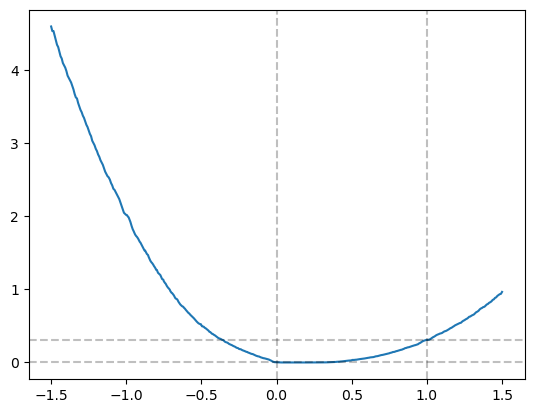

In [115]:
interp_losses = F.cross_entropy(bfunc_call(interp_sd, data.flatten(1)).flatten(0, 1), target.expand(ws.shape[0], -1).flatten(0, 1), reduction='none').unflatten(0, (ws.shape[0], -1)).mean(-1).cpu().data.to(torch.float32)

plt.plot(
    ws.cpu().data.to(torch.float32),
    interp_losses,
)
plt.axvline(0, c='k', ls='--', alpha=0.25)
plt.axhline(loss.item(), c='k', ls='--', alpha=0.25)
plt.axhline(0, c='k', ls='--', alpha=0.25)
plt.axvline(1, c='k', ls='--', alpha=0.25)
plt.show()


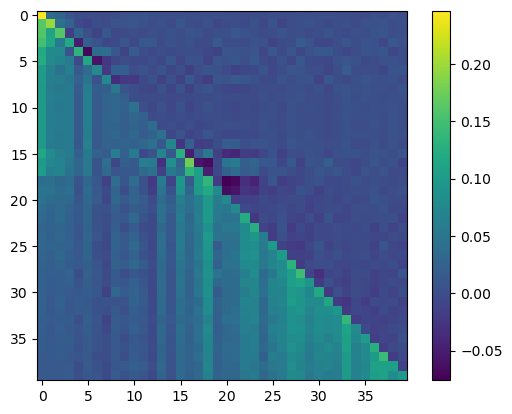

In [19]:
plt.imshow(F.cosine_similarity(updates[0:40].flatten(-2, -1)[:, None, :], grads[0:40].flatten(-2, -1)[None, :, :], dim=-1).cpu().data, interpolation='nearest')
plt.colorbar()
plt.show()



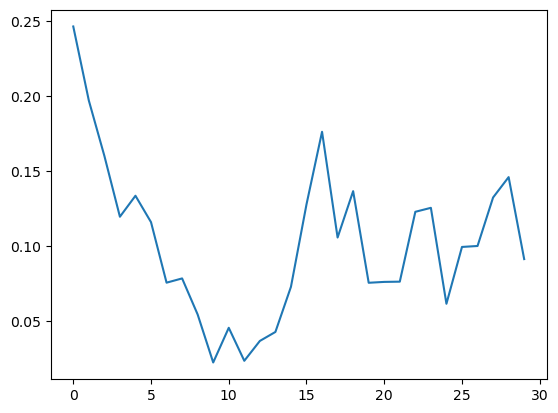

In [23]:
plt.plot(F.cosine_similarity(updates[:30].flatten(-2, -1), grads[:30].flatten(-2, -1), dim=-1).cpu().data)
plt.show()





In [138]:
import glob

for file in sorted(glob.glob('241018_300steps_bzs2048/orth*.running')):
    print(file)
    # os.rename(file, file.replace('muon_norm_fro_target', 'muon_norm_fro_exact_target'))

: 

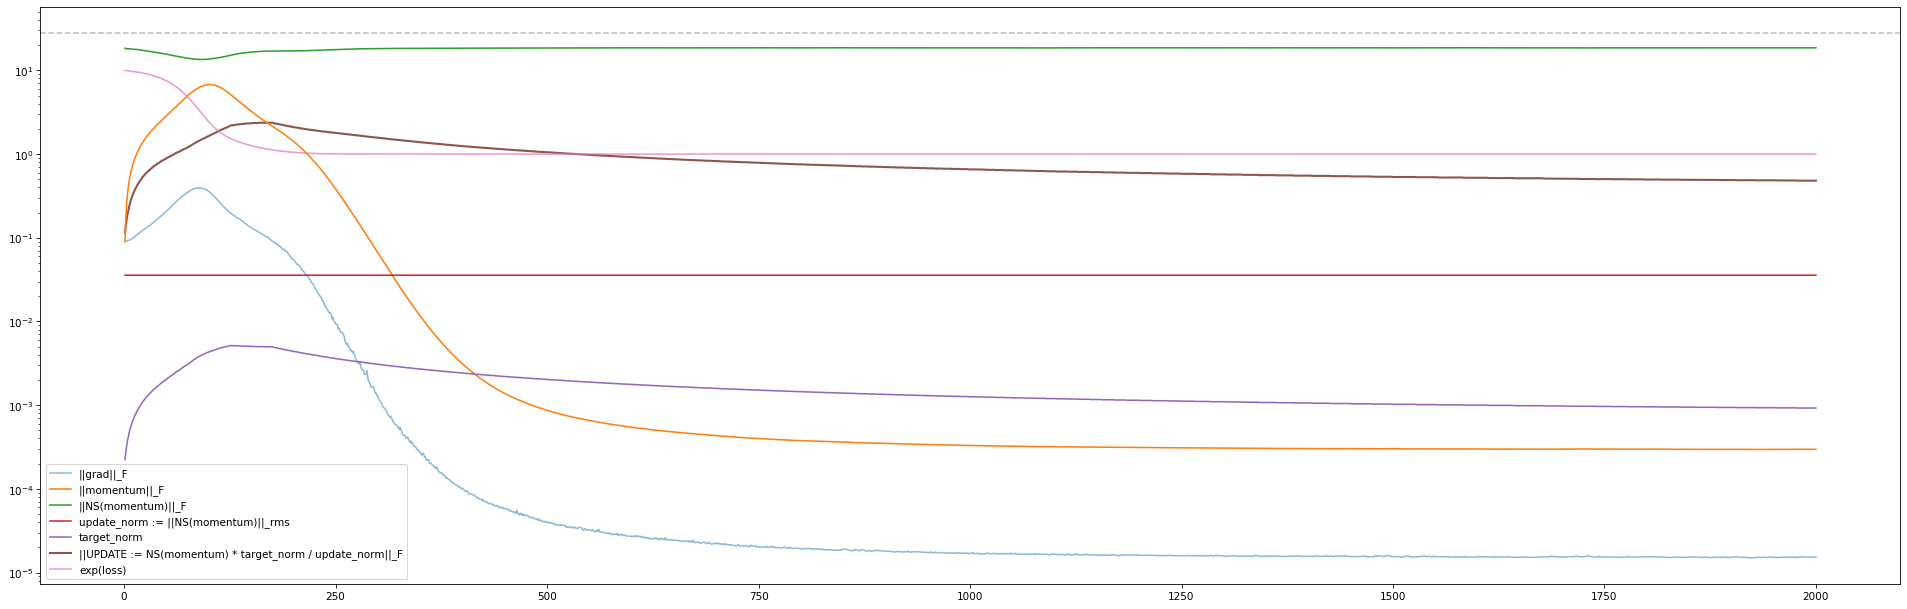

In [133]:
f, ax = plt.subplots(figsize=(32, 10), dpi=75)
plt.plot(steps, (grads.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||grad||_F', alpha=0.5)
plt.plot(steps, (momentums.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||momentum||_F', zorder=100)
plt.plot(steps, (updates.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||NS(momentum)||_F')
plt.plot(steps, (gnorms).cpu().data, label='update_norm := ||NS(momentum)||_rms', zorder=100)
plt.plot(steps, (target_norms).cpu().data, label='target_norm', zorder=100)
plt.plot(steps, (target_norms / gnorms * updates.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||UPDATE := NS(momentum) * target_norm / update_norm||_F', lw=2)
# plt.plot(steps, (momentum_0thpowers.flatten(-2, -1).norm(dim=-1)).cpu().data, label='momentum_0thpower norm')
plt.axhline(min(grads.shape[-2:]) ** 0.5, c='k', ls='--', alpha=0.25, zorder=100)
plt.plot(steps, torch.as_tensor(losses).exp().cpu().data, label='exp(loss)', alpha=0.75)
plt.yscale('log')
# plt.xscale('log')
# cap ylim to be no smaller than 1e-6 and no larger than 1e12
ymin, ymax = plt.ylim()
plt.ylim(max(ymin, 1e-12), min(ymax, 1e6))
# plt.xlim(0, 30)
plt.legend()
plt.show()